In [1]:
import torch
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline 

In [2]:
vgg = models.vgg19(pretrained = True).features

for param in vgg.parameters():
  param.requires_grad_(False)

In [3]:
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
0
1
GeForce RTX 2070 SUPER


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## Loading Images

In [5]:
def load_image(img_path, max_size = 400, shape = None):
  image = Image.open(img_path).convert('RGB')
  if max(image.size) > max_size:
    size = max_size 
  else:
    size = max(image.size)

  if shape is not None:
    size = shape

  in_transform = transforms.Compose([
                      transforms.Resize(size),
                      transforms.ToTensor(),
                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
  ])    
  image = in_transform(image).unsqueeze(0)
  return image

In [6]:
content = load_image('Images/Boston.jpg').to(device)
style = load_image('Images/VisionofWarsaw.png', shape = content.shape[-2:]).to(device)

In [7]:
def im_convert(tensor):   # to convert the tensor into numpy arrays
  image = tensor.cpu().clone().detach().numpy()
  # tensor.detach() creates a tensor that shares storage with tensor that does not require grad 
  # It detaches the output from the computational graph
  # So no gradient will be backpropagated along this variable
  image = image.squeeze() # to remove the additional dimension
  image = image.transpose(1,2,0)
  # Image is in the form of (1, 28 ,28) that is (channels, width, height)
  # We need to swap axes to convert the arrays into (28,28,1) 
  # print(image.shape)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)) # denormalize
  image = image.clip(0,1) # clip all the values outside(0,1)
  return image

(-0.5, 599.5, 399.5, -0.5)

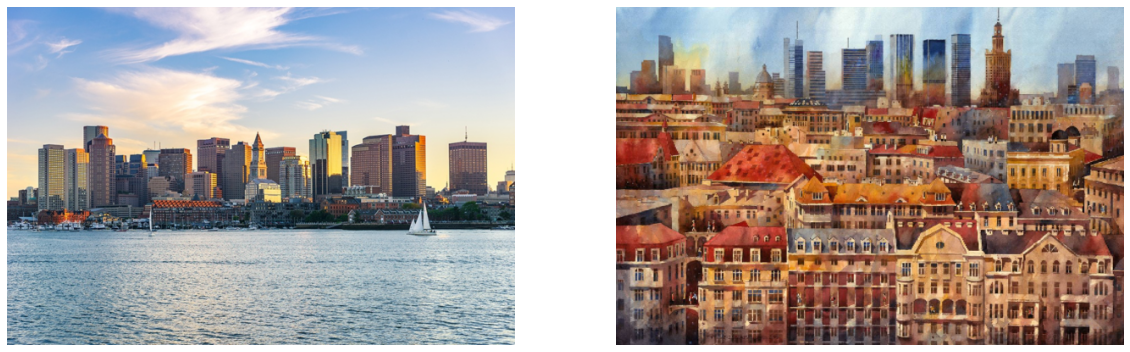

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(im_convert(content))
ax1.axis('off')
ax2.imshow(im_convert(style))
ax2.axis('off')

## Feature Extraction

In [9]:
def get_features(image, model):
  # Dict containing the specific layers that we are interested in extracting features from
  layers = {'0' : 'conv1_1', # style extraction
            '5' : 'conv2_1', # style extraction
            '10' : 'conv3_1', # style extraction
            '19' : 'conv4_1', # style extraction
            '21' : 'conv4_2', # content extraction
            '28' : 'conv5_1'} # style extraction
  # all the layers are selected from the mentioned paper as the results were phenomenal
  # We have 6 feature extraction layers, 5 of them will be used for style extraction and one for content extraction

  features = {}

  for name, layer in model._modules.items():
    image = layer(image)
    if name in layers:
      features[layers[name]] = image
  return features    


In [10]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

C:\Users\adhar\anaconda3\envs\torch-gpu\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [11]:
def gram_matrix(tensor):
  _, d, h, w = tensor.size()
  tensor = tensor.view(d, h*w)
  gram = torch.mm(tensor, tensor.t())
  return gram 

In [12]:
style_grams = {layer : gram_matrix(style_features[layer]) for layer in style_features}

Layers close to the beginning of the model are usually more effective at reacreating style features, while later layers offer additional variety towards the style elements. 

So a customized arrangement which weighs the early layers more heavily would be ideal for us

In [13]:
style_weights = {'conv1_1' : 1.,
                 'conv2_1' : 0.75,
                 'conv3_1' : 0.2,
                 'conv4_1' : 0.2,
                 'conv5_1' : 0.2}

content_weight = 1  # alpha
style_weight = 1e6  # beta, 10 to the power of six               

Though the paper uses a white noise image as a starting point for the target image, we will use our original image being a clone of our content image

The optimization process is then going to try and maintain the content of the image while applying more style from the style image with each iteration of the optimization process 

In [14]:
target = content.clone().requires_grad_(True).to(device)

## Optimization

In [15]:
show_every = 100
optimizer = optim.Adam([target], lr = 0.003)
steps = 500

height, width, channels = im_convert(target).shape
image_array = np.empty(shape=(300, height, width, channels))
capture_frame = steps/100
counter = 0

Total loss  6429764.5
Iteration 100


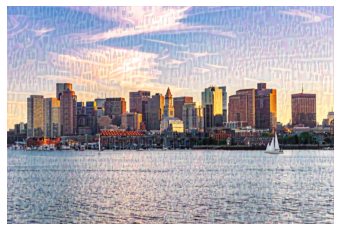

Total loss  3217449.0
Iteration 200


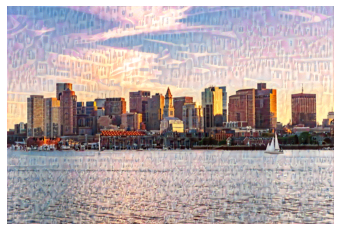

Total loss  1813318.0
Iteration 300


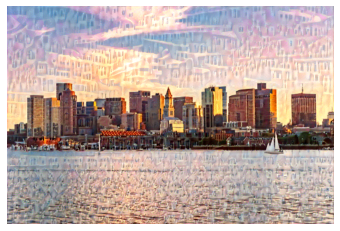

Total loss  1142854.25
Iteration 400


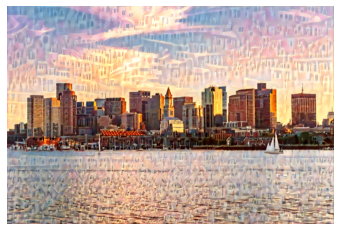

Total loss  829493.1875
Iteration 500


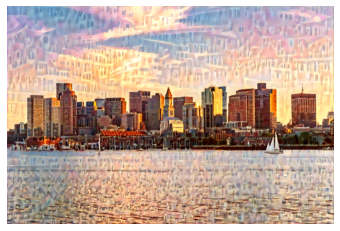

In [16]:
for ii in range(1, steps+1):
  target_features = get_features(target, vgg)
  content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) **2)
  style_loss = 0 # result of a combined loss of all the five layers

  for layer in style_weights:
    target_feature = target_features[layer]
    target_gram = gram_matrix(target_feature)
    style_gram = style_grams[layer]
    layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram) **2) # weighted loss
    _, d, h, w =  target_feature.shape
    style_loss += layer_style_loss / (d * h * w) # normalizing the loss

  total_loss = content_weight * content_loss   + style_weight * style_loss 

  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()

  if ii % show_every == 0:
    print("Total loss ", total_loss.item())
    print("Iteration", ii)
    plt.imshow(im_convert(target))
    plt.axis('off')
    plt.show()

  if ii % capture_frame == 0:
    image_array[counter] = im_convert(target)
    counter = counter + 1

In [20]:
import cv2 

frame_height, frame_width, _ = im_convert(target).shape
vid = cv2.VideoWriter('Video/boston_warsaw.mp4', cv2.VideoWriter_fourcc(*'XVID'), 30, (frame_width, frame_height))

for i in range(0, 300):
  img = image_array[i]
  img = img*255
  img = np.array(img, dtype = np.uint8)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  vid.write(img)

vid.release()

In [18]:
# !ls

To download the transformation video if Google Colab is used for optimization

In [19]:
# from google.colab import files
# files.download('output.mp4')